In [1]:
# Clone the BARTScore repository
!git clone https://github.com/neulab/BARTScore.git

Cloning into 'BARTScore'...
remote: Enumerating objects: 220, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 220 (delta 18), reused 14 (delta 14), pack-reused 194 (from 1)
Receiving objects: 100% (220/220), 101.98 MiB | 24.92 MiB/s, done.
Resolving deltas: 100% (47/47), done.
Updating files: 100% (192/192), done.


In [2]:
%cd /content/BARTScore

/content/BARTScore


In [3]:
# Import libraries
from bart_score import BARTScorer
import torch

In [4]:
# Install necessary libraries
!pip install --upgrade pip  # ensures that pip is current
!pip install tensorflow tensorflow_hub transformers
!pip install git+https://github.com/google-research/bleurt.git
!pip install pandas
!pip install groq
!pip install scikit-learn
!pip install matplotlib
!pip install nltk
!pip install rouge
!pip install sacrebleu
!pip install bert-score
!pip install rouge
# Navigate to the repository directory
%cd /content/BARTScore

# Download and unzip BLEURT checkpoint
!wget https://storage.googleapis.com/bleurt-oss-21/BLEURT-20.zip
!unzip BLEURT-20.zip


# Import libraries
from bart_score import BARTScorer
import torch

# Initialize BART-Scorer
bart_scorer = BARTScorer(device='cuda:0' if torch.cuda.is_available() else 'cpu',
                         checkpoint='facebook/bart-large-cnn')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.8 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
  Cloning https://github.com/google-research/bleurt.git to /tmp/pip-req-build-fxcd6xg_
  Running command git clone --filter=blob:none --quiet https://github.com/google-research/bleurt.git /tmp/pip-req-build-fxcd6xg_
  Resolved https://github.com/google-research/bleurt.git to commit cebe7e6f996b40910cfaa520a63db47807e3bf5c
  Preparing metadata (setup.py) ... done
  Created wheel for BLEURT: filename=BLEURT-0.0.2-py3-none-any.whl size=16456764 sha256=da5efef710b4cfa6ddb7f86436e16cb5a74a3a393c4069c9feb566a51e3f1ece
  Stored in directory: /tmp/pip-ephem-wheel-cache-33n98sbu/wheels/64/f4/2c/509a6c31b8ebde891a81029fd94f199b1b92f0e7cfc20d417a
Successfully built BLEURT
/content/BARTScore
--2025-01-15 12:48:15--  https://storage.googleapis.com/bleurt-oss-21/BLEURT-20.zip
Resolvi

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

In [5]:
import tensorflow as tf
import tensorflow_hub as hub
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from sacrebleu.metrics import CHRF, TER
from bert_score import score
from bleurt import score as bleurt_score
import json
import pandas as pd
import random
import warnings
from groq import Groq
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge import Rouge
from nltk.translate.meteor_score import meteor_score
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Suppress specific warning messages
import logging
logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)

# Function to read JSON file and extract claims
def read_claims_from_json(file_path):
    try:
        with open(file_path, 'r') as file:
            data = json.load(file)
        return data
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return []
    except json.JSONDecodeError:
        print(f"Error decoding JSON from file: {file_path}")
        return []

# Load your dataset from JSON files
claims_file_1 = '/content/last_fake_claims.json'
claims_file_2 = '/content/Modified_true_claims.json'

claims_data_1 = read_claims_from_json(claims_file_1)
claims_data_2 = read_claims_from_json(claims_file_2)

# Combine claims from both files
combined_claims = claims_data_1 + claims_data_2
random.shuffle(combined_claims)

# Extract relevant information and convert to DataFrame
claims_list = []
for claim in combined_claims:
    claims_list.append({
        'Text': claim['claim'],
        'classification_label': claim['label'],
        'justification': claim['justification']
    })

claims_df = pd.DataFrame(claims_list)

# Process only the first 10 claims
claims_df = claims_df.head(5006)

# Initialize Groq API client
client = Groq(api_key="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")

# Initialize label map
label_map = {'true': 'true', 'fake': 'fake', "correct": "true", "false": "fake", "incorrect": "fake", "not true": "fake","true:" : "true","fake:": "fake"}

# Define the function to get predictions
def get_claim_predictions(claim):
    prompt = f"Determine the validity of the following claim and label it as 'TRUE' or 'FAKE'. Provide only 'TRUE' or 'FAKE' on the first line, followed by a justification on the second line: {claim}"

    try:
        response = client.chat.completions.create(
            messages=[
                {
                    "role": "user",
                    "content": prompt,
                }
            ],
            model="mixtral-8x7b-32768",
            max_tokens=4000,
        )

        predicted_result = response.choices[0].message.content.strip().splitlines()
        print(predicted_result)
        predicted_label_justification = predicted_result[0].strip(' .,*').lower()
        if ':' in predicted_label_justification:
            predicted_label, predicted_justification = predicted_label_justification.split(':', 1)
            predicted_label = predicted_label.strip()
            predicted_justification = predicted_justification.strip()
        else:
            predicted_label = predicted_label_justification
            predicted_justification = " ".join(predicted_result[1:]).strip().lower()

        if predicted_label in label_map:
            predicted_label = label_map[predicted_label]
        else:
            # Handle cases where the label is not clear
            predicted_label = "unknown"
            predicted_justification = " ".join(predicted_result).strip().lower()
    except Exception as e:
        print(f"Error processing claim '{claim}': {e}")
        return ("", "", "")

    return (prompt, predicted_label, predicted_justification)

# Evaluate claims
results = []
actual_labels = []
predicted_labels = []
predicted_justifications = []
actual_justifications = []

correct_predictions = 0
total_processed_claims = 0

for index, row in claims_df.iterrows():
    claim = row['Text']
    actual_label = str(row['classification_label'].strip().lower())
    actual_justification = str(row['justification'].strip().lower())

    prompt, predicted_label, predicted_justification = get_claim_predictions(claim)

    total_processed_claims += 1

    if (predicted_label, predicted_justification) == ("", ""):
        continue

    actual_labels.append(actual_label)
    actual_justifications.append(actual_justification)
    predicted_labels.append(predicted_label)
    predicted_justifications.append(predicted_justification)

    if predicted_label == actual_label:
        correct_predictions += 1
    print(f"Claim #{total_processed_claims}")
    print(f"Prompt: {prompt}")
    print(f"Claim: {claim}")
    print(f"Predicted Label: {predicted_label}")
    print(f"Actual Label: {actual_label}")
    print(f"Predicted Justification: {predicted_justification}")
    print(f"Actual Justification: {actual_justification}")
    print('-' * 50)

# Metrics initialization
rouge = Rouge()
smoothing_function = SmoothingFunction().method4
chrf = CHRF()
ter = TER()
bleurt_scorer = bleurt_score.BleurtScorer("BLEURT-20")

# Filter out empty justifications
filtered_justifications = [
    (actual, predicted)
    for actual, predicted in zip(actual_justifications, predicted_justifications)
    if predicted.strip()
]

# Calculate metrics
def calculate_metrics_extended(justifications):
    bleu_scores = []
    rouge_scores = []
    meteor_scores = []
    chrf_scores = []
    ter_scores = []
    bert_scores = []
    bleurt_scores = []
    bart_scores = []

    for ref, pred in justifications:
        # BLEU score
        bleu = sentence_bleu([ref.split()], pred.split(), smoothing_function=smoothing_function)
        bleu_scores.append(bleu)

        # ROUGE score
        rouge_score = rouge.get_scores(pred, ref, avg=True)
        rouge_scores.append(rouge_score)

        # METEOR score
        meteor = meteor_score([ref.split()], pred.split())
        meteor_scores.append(meteor)

        # ChrF
        chrf_scores.append(chrf.corpus_score([pred], [[ref]]).score)

        # TER
        ter_scores.append(ter.corpus_score([pred], [[ref]]).score)

        # BERTScore
        P, R, F1 = score([pred], [ref], lang="en")
        bert_scores.append(F1.mean().item())

        # BLEURT
        bleurt_scores.append(bleurt_scorer.score(references=[ref], candidates=[pred])[0])

        # BARTScore
        bart_scores.append(bart_scorer.score([pred], [ref])[0])

    return bleu_scores, rouge_scores, meteor_scores, chrf_scores, ter_scores, bert_scores, bleurt_scores, bart_scores

# Calculate metrics
bleu_scores, rouge_scores, meteor_scores, chrf_scores, ter_scores, bert_scores, bleurt_scores, bart_scores = calculate_metrics_extended(filtered_justifications)

# Summarize and print results
avg_rouge_1 = sum([score['rouge-1']['f'] for score in rouge_scores]) / len(rouge_scores)
avg_rouge_2 = sum([score['rouge-2']['f'] for score in rouge_scores]) / len(rouge_scores)
avg_rouge_l = sum([score['rouge-l']['f'] for score in rouge_scores]) / len(rouge_scores)

print(f"Average BLEU Score: {sum(bleu_scores) / len(bleu_scores):.4f}")
print(f"Average METEOR Score: {sum(meteor_scores) / len(meteor_scores):.4f}")
print(f"Average ChrF Score: {sum(chrf_scores) / len(chrf_scores):.4f}")
print(f"Average TER Score: {sum(ter_scores) / len(ter_scores):.4f}")
print(f"Average BERTScore F1: {sum(bert_scores) / len(bert_scores):.4f}")
print(f"Average BLEURT Score: {sum(bleurt_scores) / len(bleurt_scores):.4f}")
print(f"Average BARTScore: {sum(bart_scores) / len(bart_scores):.4f}")
print(f"Average ROUGE-1 F1 Score: {avg_rouge_1:.4f}")
print(f"Average ROUGE-2 F1 Score: {avg_rouge_2:.4f}")
print(f"Average ROUGE-L F1 Score: {avg_rouge_l:.4f}")

# Calculate accuracy
accuracy = (correct_predictions / total_processed_claims) * 100 if total_processed_claims > 0 else 0
print(f"Model Accuracy: {accuracy:.2f}%")

# Calculate the F1 score
f1 = f1_score(actual_labels, predicted_labels, average='weighted', labels=["true", "fake"])
print(f"F1 Score Average: {f1}")

# Confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels, labels=["true", "fake"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["true", "fake"])
disp.plot(cmap=plt.cm.Blues)
plt.show()

Streaming output truncated to the last 5000 lines.
Predicted Label: fake
Actual Label: fake
Predicted Justification: justification: the conflict between israel and palestine is a long-standing issue with roots in historical, political, and religious disagreements. it is not caused by the actions of any single individual or recent event. blaming the american president for this conflict would be an oversimplification and misrepresentation of the complexities involved.
Actual Justification: the claim is false. the video has been mistranslated. in the original speech from 2020, kim jong un did not mention the israel-palestine conflict. the video shows him paying tribute to north korean troops for their response to the covid-19 outbreak.
--------------------------------------------------
['FAKE', '', 'The claim made by AAP leader Somnath Bharti that IIT dropped his name from an alumni award list under BJP pressure is not supported by any concrete evidence. IIT Delhi has denied this claim, s

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Average BLEU Score: 0.0683
Average METEOR Score: 0.2853
Average ChrF Score: 38.8837
Average TER Score: 156.1114
Average BERTScore F1: 0.8781
Average BLEURT Score: 0.4802
Average BARTScore: -3.0310
Average ROUGE-1 F1 Score: 0.3210
Average ROUGE-2 F1 Score: 0.1215
Average ROUGE-L F1 Score: 0.2830
Model Accuracy: 55.73%
F1 Score Average: 0.5685634463213983


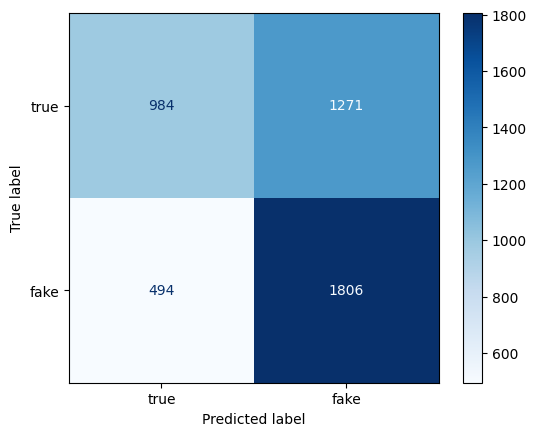

In [7]:
print(f"Average BLEU Score: {sum(bleu_scores) / len(bleu_scores):.4f}")
print(f"Average METEOR Score: {sum(meteor_scores) / len(meteor_scores):.4f}")
print(f"Average ChrF Score: {sum(chrf_scores) / len(chrf_scores):.4f}")
print(f"Average TER Score: {sum(ter_scores) / len(ter_scores):.4f}")
print(f"Average BERTScore F1: {sum(bert_scores) / len(bert_scores):.4f}")
print(f"Average BLEURT Score: {sum(bleurt_scores) / len(bleurt_scores):.4f}")
print(f"Average BARTScore: {sum(bart_scores) / len(bart_scores):.4f}")
print(f"Average ROUGE-1 F1 Score: {avg_rouge_1:.4f}")
print(f"Average ROUGE-2 F1 Score: {avg_rouge_2:.4f}")
print(f"Average ROUGE-L F1 Score: {avg_rouge_l:.4f}")

# Calculate accuracy
accuracy = (correct_predictions / total_processed_claims) * 100 if total_processed_claims > 0 else 0
print(f"Model Accuracy: {accuracy:.2f}%")

# Calculate the F1 score
f1 = f1_score(actual_labels, predicted_labels, average='weighted', labels=["true", "fake"])
print(f"F1 Score Average: {f1}")

# Confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels, labels=["true", "fake"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["true", "fake"])
disp.plot(cmap=plt.cm.Blues)
plt.show()